## Importation des modules et des données 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

In [4]:
acte = pd.read_csv("acte.csv", sep = ";")
ccam = pd.read_csv("ccam.csv",sep = ";")
h = pd.read_csv("h.csv",sep = ";")

## Création du tableau de données exploitable

### Merge des tableaux

In [5]:
data = h.merge(acte)

In [6]:
data = data.merge(ccam).sort_values('i')

### Création du tableau d'étude

In [7]:
def get_val(values):
    return list(values)
def get_count(values):
    return len(values)
def get_chap(values):
    return list(set(values))


In [8]:
df = data.groupby('i').ccam_code.agg(get_val)
df = df.to_frame()
df["nb_codes"] = df.ccam_code.agg(get_count)
df["d"] = data.groupby('i').d.mean()
df["ccam_lib"] = data.groupby('i').ccam_lib.agg(get_val)

In [9]:
df['chapitre'] = data.groupby('i').chapitre_lib.agg(get_chap)
df['sous_chapitre'] = data.groupby('i').sous_chapitre_lib.agg(get_chap)
df['paragraphe']= data.groupby('i').paragraphe_lib.agg(get_chap)
df['sous_paragraphe'] = data.groupby('i').sous_paragraphe_lib.agg(get_chap)

### Création du tableau de contingence

In [10]:
X = pd.DataFrame()

In [11]:
list_codes = data['ccam_lib'].unique()
for i in range (len(list_codes)):
    X[str(list_codes[i])] = df['ccam_lib'].apply(lambda x : x.count(list_codes[i]))
X.head(5)

,"Ablation d'une endoprothèse urétérale, par endoscopie rétrograde","Changement d'une endoprothèse urétérale, par endoscopie rétrograde",Urétéropyélographie rétrograde [UPR],Urétrocystoscopie à l'endoscope rigide,Guidage radiologique,"Changement d'une sonde urétérale, par endoscopie rétrograde",Supplément pour injection peropératoire de produit de contraste radiologique dans les voies excrétrices urinaires pour prises de clichés radiologiques,"Fragmentation intrarénale de calcul caliciel inférieur avec ondes de choc ou laser [Lithotritie intrarénale], par urétéronéphroscopie",Pose d'une sonde urétrovésicale [Sondage vésical à demeure],"Résection d'une hypertrophie de la prostate sans laser, par urétrocystoscopie","Cystostomie cutanée continente sans fermeture du col de la vessie, par laparotomie",Évacuation de la vessie par cathétérisme transitoire [Sondage vésical évacuateur],"Résection de 1 à 3 tumeurs de la vessie, par endoscopie","Destruction d une hypertrophie de la prostate par laser [photovaporisation], par urétrocystoscopie","Urétéroscopie rétrograde, par voie urétrale","Pose d'une sonde urétérale à visée thérapeutique, par endoscopie rétrograde","Pose d'une endoprothèse urétérale, par endoscopie rétrograde","Dilatation de l'uretère, par urétéroscopie rétrograde","Ablation et/ou fragmentation de calcul de l'uretère lombal, par urétéroscopie rétrograde","Implantation d'électrode de stimulation de la moelle épinière à visée thérapeutique par voie transcutanée, avec implantation souscutanée d'un générateur de stimulation neurologique","Injection de toxine botulique dans la musculeuse vésicale, par urétrocystoscopie","Pose d'une prothèse sphinctérienne urinaire périurétrale pénienne ou bulbomembranacée [bulbomembraneuse], par abord direct","Néphrectomie partielle, par coelioscopie ou par rétropéritonéoscopie","Urétrocervicoplastie de continence avec entérocystoplastie d'agrandissement, par laparotomie","Cystostomie cutanée continente avec fermeture du col de la vessie, par laparotomie","Incision du sphincter strié de l'urètre, par endoscopie","Ablation de calcul ou de corps étranger de la vessie, par endoscopie",Changement d'une sonde d'urétérostomie cutanée,"Cystectomie partielle, par coelioscopie","Entérocystoplastie d'agrandissement par anse détubulée, par laparotomie","Pose d'une endoprothèse de l'urètre cervicoprostatique, par endoscopie",Ablation d'un générateur souscutané de stimulation du système nerveux central,"Ablation d'électrode de stimulation de la moelle épinière, par voie transcutanée","Vésiculo-prostato-cystectomie totale avec urétérostomie cutanée transintestinale par anse non détubulée, par laparotomie","Curage lymphonodal [ganglionnaire] iliaque unilatéral ou bilatéral, par laparotomie","Incision cervicale ou cervicoprostatique, par endoscopie","Résection d'une hypertrophie de la prostate avec laser, par urétrocystoscopie","Fragmentation intrarénale de calcul avec ondes de choc ou laser [Lithotritie intrarénale], par urétéronéphroscopie","Biopsie de la voie excrétrice supérieure, par endoscopie rétrograde",Fibroscopie urétrovésicale,"Cystectomie totale avec urétérostomie cutanée transintestinale par anse non détubulée, par laparotomie","Néphrectomie totale unilatérale, par coelioscopie ou par rétropéritonéoscopie","Orchidopexie, par abord scrotal","Biopsie unilatérale du testicule, par abord direct","Ablation et/ou fragmentation de calcul de l'uretère pelvien, par urétéroscopie rétrograde","Ablation et/ou fragmentation de calcul de l'uretère iliaque, par urétéroscopie rétrograde","Pose d'une endoprothèse de l'urètre, par endoscopie",Posthectomie,"Ligature, section ou résection unilatérale ou bilatérale du conduit déférent, par abord scrotal","Néphrectomie totale unilatérale, par laparotomie","Urétéro-pyélo-caliscopie rétrograde, par voie urétrale","Urétéropyélographie descendante, par voie transcutanée avec guidage échographique et/ou radiologique","Néphrectomie totale élargie à la loge rénale, par coel

In [12]:
list_chap = data['chapitre_lib'].unique()
list_sous_chap = data['sous_chapitre_lib'].unique()
list_para = data['paragraphe_lib'].unique()
list_sous_para = data['sous_paragraphe_lib'].unique()

for i in range (len(list_chap)):
    X[str(list_chap[i])] = df['chapitre'].apply(lambda x : 1 if list_chap[i] in x else 0)
    
for i in range (len(list_sous_chap)):
    X[str(list_sous_chap[i])] = df['chapitre'].apply(lambda x : 1 if list_sous_chap[i] in x else 0)
    
for i in range (len(list_para)):
    X[str(list_para[i])] = df['chapitre'].apply(lambda x : 1 if list_para[i] in x else 0)
    
for i in range (len(list_sous_para)):
    X[str(list_sous_para[i])] = df['chapitre'].apply(lambda x : 1 if list_sous_para[i] in x else 0)

In [13]:
X["nb_codes"] = df["nb_codes"]
X["d"] = df["d"]

### 1. Arbre de régression ( naif )

In [14]:
from sklearn import tree,model_selection
from numpy import log

In [15]:
clf = tree.DecisionTreeRegressor(random_state=0,max_depth=5)

In [16]:
x = X.drop(columns = 'd') # les données sans la durée
y = X['d'] # les label à prédire

#### Entrainement

In [17]:
fig = clf.fit(x,y)
print("nombre de feuille : ",fig.get_n_leaves())
print("profondeur : ", fig.get_depth())

nombre de feuille :  14
profondeur :  5


In [18]:
p = fig.predict(x) # prédiction
MAPE = np.mean(abs(p-y)*100/y)

In [19]:
p = fig.predict(x)
data = x.copy()
data["d_pred"] = p
data["d_vrai"] = y

In [20]:
d = data.groupby(["d_pred"]).agg(écart_type = ("d_vrai", "std"), 
                                 compteur = ("d_pred", "count"),
                                 moyenne = ("d_vrai","mean"),
                                 minimum = ('d_vrai','min'),
                                 maximum = ('d_vrai','max'))

d.sort_values(by = 'd_pred', ascending = True)

,écart_type,compteur,moyenne,minimum,maximum
d_pred,,,,,
6459.230769,4956.794277,2002,6459.230769,900.0,39300.0
14500.000000,780.768852,3,14500.000000,13740.0,15300.0
15000.000000,NaN,1,15000.000000,15000.0,15000.0
16984.883721,3086.854003,86,16984.883721,11760.0,26040.0
18480.000000,0.000000,2,18480.000000,18480.0,18480.0
18502.857143,3228.106963,42,18502.857143,12120.0,28680.0
18600.000000,NaN,1,18600.000000,18600.0,18600.0
23822.142857,4636.506793,28,23822.142857,15060.0,32700.0
26880.000000,4806.994903,13,26880.000000,20040.0,34320.0


In [21]:
MAPE = np.mean(abs(p-y)*100/y)
PE = (p-y)*100/y
within, overage, underage = 0, 0, 0
for i in PE:
    if i < -10:
        underage += 1
    elif i > 10:
        overage += 1 
    else : 
        within += 1
        
total = within + overage + underage
within = within*100/total
overage = overage*100/total
underage = underage*100/total


print("Score : ",fig.score(x,y))
print("MAPE : ", MAPE)
print("dans l'intervalle 10% : ", within)
print("Surestimé : ",overage)
print("Sous estimé : ",underage)

Score :  0.4108929561522684
MAPE :  62.42059177779261
dans l'intervalle 10% :  15.170842824601367
Surestimé :  58.45102505694761
Sous estimé :  26.378132118451024


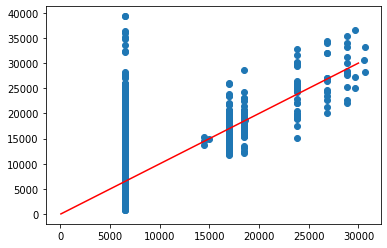

In [22]:
plt.scatter(p,y)
plt.plot([50,30000],[50,30000],"-r")
plt.show()

### 2. Réglage des paramètres

- Max depth : Maximum de profondeur de l'arbre
- min sample_split : Nombre d'observation minimale pour qu'un noeud produise 2 fueilles 
- min sample leaf : Nombre d'observation minimale dans chaque feuille (dans chaque classe)

Pour ces deux paramètres : 

élevé --> sous apprentissage, bas --> Sur apprentissage
- Max leaf_nodes : Nombre maximale de feuille ( donc nombre maximal de classe )
- min_impurity decrease : a chaque noeud l'arbre calcul une fonction qui représente si les observations dans ce noeud sont bien classé ( c'est à dire qu'elle sont proches au seins de la classe mais loin des autres classes) et si la valeur de cette fonction est trop élévé alors on divise ce noeud. La valeur du paramètre permet de régler cette valeur seuil.

élévé --> sous apprentissage, bas --> Sur apprentissage




In [23]:
clf = tree.DecisionTreeRegressor(criterion = 'squared_error',
                                     max_depth = 20,
                                     min_samples_split=10,
                                     min_samples_leaf=10,
                                     random_state=0,
                                     max_leaf_nodes=15,
                                     min_impurity_decrease = 0,
                                     ccp_alpha= 1)

#### Entrainement

In [30]:
fig = clf.fit(x,y)
print("nombre de feuille : ",fig.get_n_leaves())
print("profondeur : ", fig.get_depth())


nombre de feuille :  15
profondeur :  14


### Analyse des classes

In [31]:
# Reconstition du tableau
p = fig.predict(x)
data = x.copy()
data["d_pred"] = p
data["d_vrai"] = y
data

,"Ablation d'une endoprothèse urétérale, par endoscopie rétrograde","Changement d'une endoprothèse urétérale, par endoscopie rétrograde",Urétéropyélographie rétrograde [UPR],Urétrocystoscopie à l'endoscope rigide,Guidage radiologique,"Changement d'une sonde urétérale, par endoscopie rétrograde",Supplément pour injection peropératoire de produit de contraste radiologique dans les voies excrétrices urinaires pour prises de clichés radiologiques,"Fragmentation intrarénale de calcul caliciel inférieur avec ondes de choc ou laser [Lithotritie intrarénale], par urétéronéphroscopie",Pose d'une sonde urétrovésicale [Sondage vésical à demeure],"Résection d'une hypertrophie de la prostate sans laser, par urétrocystoscopie","Cystostomie cutanée continente sans fermeture du col de la vessie, par laparotomie",Évacuation de la vessie par cathétérisme transitoire [Sondage vésical évacuateur],"Résection de 1 à 3 tumeurs de la vessie, par endoscopie","Destruction d une hypertrophie de la prostate par laser [photovaporisation], par urétrocystoscopie","Urétéroscopie rétrograde, par voie urétrale","Pose d'une sonde urétérale à visée thérapeutique, par endoscopie rétrograde","Pose d'une endoprothèse urétérale, par endoscopie rétrograde","Dilatation de l'uretère, par urétéroscopie rétrograde","Ablation et/ou fragmentation de calcul de l'uretère lombal, par urétéroscopie rétrograde","Implantation d'électrode de stimulation de la moelle épinière à visée thérapeutique par voie transcutanée, avec implantation souscutanée d'un générateur de stimulation neurologique","Injection de toxine botulique dans la musculeuse vésicale, par urétrocystoscopie","Pose d'une prothèse sphinctérienne urinaire périurétrale pénienne ou bulbomembranacée [bulbomembraneuse], par abord direct","Néphrectomie partielle, par coelioscopie ou par rétropéritonéoscopie","Urétrocervicoplastie de continence avec entérocystoplastie d'agrandissement, par laparotomie","Cystostomie cutanée continente avec fermeture du col de la vessie, par laparotomie","Incision du sphincter strié de l'urètre, par endoscopie","Ablation de calcul ou de corps étranger de la vessie, par endoscopie",Changement d'une sonde d'urétérostomie cutanée,"Cystectomie partielle, par coelioscopie","Entérocystoplastie d'agrandissement par anse détubulée, par laparotomie","Pose d'une endoprothèse de l'urètre cervicoprostatique, par endoscopie",Ablation d'un générateur souscutané de stimulation du système nerveux central,"Ablation d'électrode de stimulation de la moelle épinière, par voie transcutanée","Vésiculo-prostato-cystectomie totale avec urétérostomie cutanée transintestinale par anse non détubulée, par laparotomie","Curage lymphonodal [ganglionnaire] iliaque unilatéral ou bilatéral, par laparotomie","Incision cervicale ou cervicoprostatique, par endoscopie","Résection d'une hypertrophie de la prostate avec laser, par urétrocystoscopie","Fragmentation intrarénale de calcul avec ondes de choc ou laser [Lithotritie intrarénale], par urétéronéphroscopie","Biopsie de la voie excrétrice supérieure, par endoscopie rétrograde",Fibroscopie urétrovésicale,"Cystectomie totale avec urétérostomie cutanée transintestinale par anse non détubulée, par laparotomie","Néphrectomie totale unilatérale, par coelioscopie ou par rétropéritonéoscopie","Orchidopexie, par abord scrotal","Biopsie unilatérale du testicule, par abord direct","Ablation et/ou fragmentation de calcul de l'uretère pelvien, par urétéroscopie rétrograde","Ablation et/ou fragmentation de calcul de l'uretère iliaque, par urétéroscopie rétrograde","Pose d'une endoprothèse de l'urètre, par endoscopie",Posthectomie,"Ligature, section ou résection unilatérale ou bilatérale du conduit déférent, par abord scrotal","Néphrectomie totale unilatérale, par laparotomie","Urétéro-pyélo-caliscopie rétrograde, par voie urétrale","Urétéropyélographie descendante, par voie transcutanée avec guidage échographique et/ou radiologique","Néphrectomie totale élargie à la loge rénale, par coel

In [32]:
d = data.groupby(["d_pred"]).agg(écart_type = ("d_vrai", "std"), 
                                 compteur = ("d_pred", "count"),
                                 moyenne_vrai = ("d_vrai","mean"),
                                 minimum = ('d_vrai','min'),
                                 maximum = ('d_vrai','max'))

d.sort_values(by = 'd_pred', ascending = True)

,écart_type,compteur,moyenne_vrai,minimum,maximum
d_pred,,,,,
3123.243243,1435.196568,37,3123.243243,1680.0,7620.0
3309.512195,768.633391,82,3309.512195,1740.0,5700.0
4111.782178,1762.089949,202,4111.782178,900.0,12300.0
4812.021467,2583.692731,559,4812.021467,900.0,23280.0
7214.617737,5405.163780,981,7214.617737,900.0,39300.0
10728.705882,3140.202370,85,10728.705882,4200.0,19860.0
15480.000000,2720.455844,11,15480.000000,11580.0,19800.0
16794.000000,1761.465299,10,16794.000000,14040.0,18720.0
16997.528090,3050.160682,89,16997.528090,11760.0,26040.0


In [33]:
MAPE = np.mean(abs(p-y)*100/y)
PE = (p-y)*100/y
within, overage, underage = 0, 0, 0
for i in PE:
    if i < -10:
        underage += 1
    elif i > 10:
        overage += 1 
    else : 
        within += 1
        
total = within + overage + underage
within = within*100/total
overage = overage*100/total
underage = underage*100/total


print("Score : ",fig.score(x,y))
print("MAPE : ", MAPE)
print("dans l'intervalle 10% : ", within)
print("Surestimé : ",overage)
print("Sous estimé : ",underage)

Score :  0.5709035908401328
MAPE :  47.94704518348856
dans l'intervalle 10% :  17.12984054669704
Surestimé :  55.30751708428246
Sous estimé :  27.5626423690205


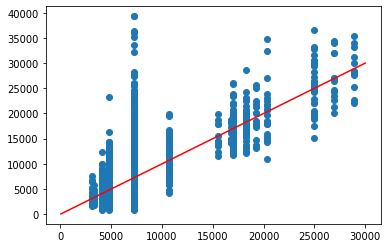

In [34]:
plt.scatter(p,y)
plt.plot([50,30000],[50,30000],"-r")
plt.show()

Amélioration notable 

15% à 17% dans l'intervalle de confiance

0,41 à 0,57 de score R^2 

In [36]:
from sklearn.tree import export_text

tree_rules = export_text(fig, feature_names = list(x.columns),max_depth = 20)
print(tree_rules)

|--- Vésiculoprostatectomie totale, par coelioscopie <= 0.50
|   |--- Transplantation du rein <= 0.50
|   |   |--- Néphrectomie partielle, par coelioscopie ou par rétropéritonéoscopie <= 0.50
|   |   |   |--- Cystectomie totale avec urétérostomie cutanée transintestinale par anse non détubulée, par laparotomie <= 0.50
|   |   |   |   |--- Vésiculo-prostato-cystectomie totale avec urétérostomie cutanée transintestinale par anse non détubulée, par laparotomie <= 0.50
|   |   |   |   |   |--- Néphrectomie totale unilatérale, par coelioscopie ou par rétropéritonéoscopie <= 0.50
|   |   |   |   |   |   |--- Néphrectomie totale élargie à la loge rénale, par coelioscopie ou rétropéritonéoscopie <= 0.50
|   |   |   |   |   |   |   |--- Résection d'une hypertrophie de la prostate avec laser, par urétrocystoscopie <= 0.50
|   |   |   |   |   |   |   |   |--- Hystéropexie postérieure [Promontofixation], par coelioscopie <= 0.50
|   |   |   |   |   |   |   |   |   |--- ADAPTATIONS POUR LA CCAM TRA

### Analyse d'une classe

In [51]:
classe_3 = data[data["d_pred"]==data['d_pred'][3]]
c = pd.DataFrame(classe_3.sum())
c.sort_values(by = 0,ascending = False)

,0
d_pred,7077540.0
d_vrai,7077540.0
nb_codes,1414.0
APPAREIL URINAIRE ET GÉNITAL,913.0
"Pose d'une endoprothèse urétérale, par endoscopie rétrograde",155.0
"Résection de 1 à 3 tumeurs de la vessie, par endoscopie",114.0
Pose d'une sonde urétrovésicale [Sondage vésical à demeure],77.0
"Résection de 4 tumeurs de la vessie ou plus, par endoscopie",62.0
"Pose d'une sonde urétérale à visée thérapeutique, par endoscopie rétrograde",53.0
Urétéropyélographie rétrograde [UPR],47.0


### Analyse des classes générées

***Histogrammes de chaque classe***

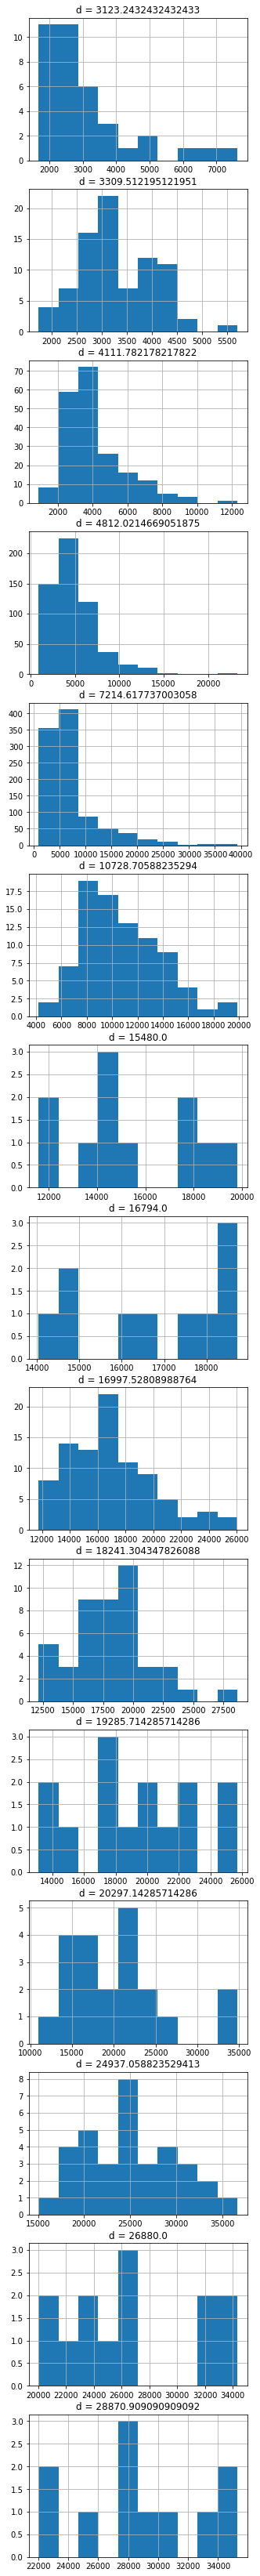

In [33]:
classe = list(data['d_pred'].unique())
classe_s = sorted(classe)

i = 0

fig, ax = plt.subplots(nrows=len(classe), ncols=1,figsize=(5, 30))

for c in classe_s:
    f = data[data["d_pred"]==c]
    ax[i].hist(f['d_vrai'])
    ax[i].set_title("d = " + str(c))
    ax[i].grid()
    i+=1
plt.gcf().subplots_adjust(bottom = 0.5, top = 2)

***Boite à moustache de chaque classe***

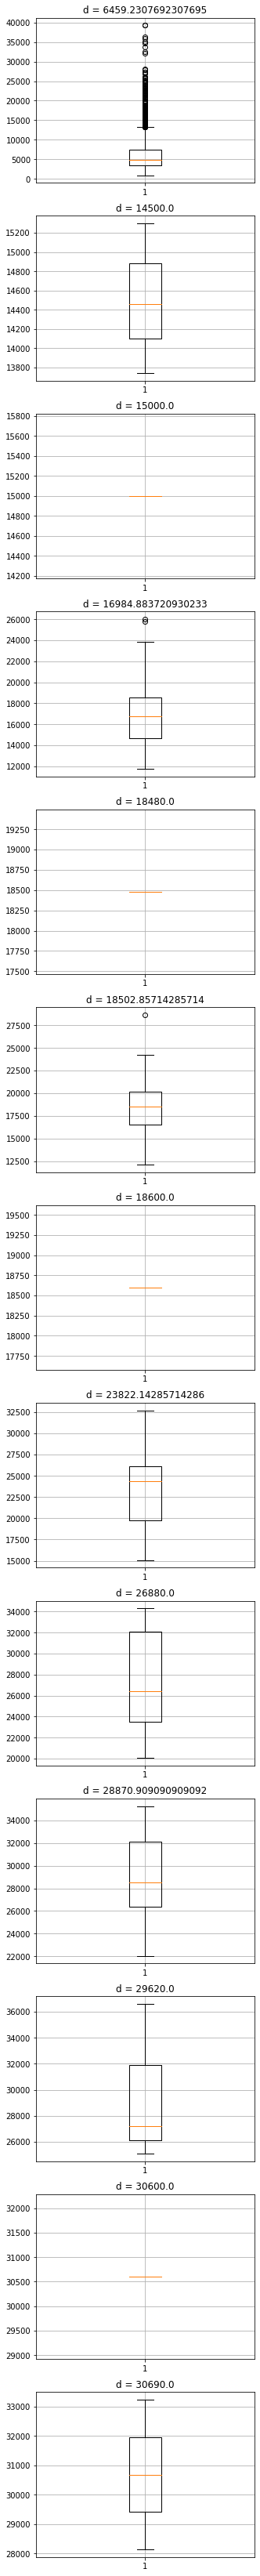

In [65]:
classe = list(data['d_pred'].unique())
classe_s = sorted(classe)

i = 0

fig, ax = plt.subplots(nrows=len(classe), ncols=1,figsize=(5, 30))

for c in classe_s:
    f = data[data["d_pred"]==c]
    ax[i].boxplot(f['d_vrai'])
    ax[i].set_title("d = " + str(c))
    ax[i].grid()
    i+=1
plt.gcf().subplots_adjust(bottom = 0.5, top = 2)

### 3. durée en logarithme

In [35]:
from numpy import log,exp

In [36]:
y_log = log(y)

In [37]:
clf = tree.DecisionTreeRegressor(criterion = 'squared_error',
                                 max_depth = 20,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 random_state=0,
                                 max_leaf_nodes=15,
                                 min_impurity_decrease = 0,
                                 ccp_alpha= 0)
fig = clf.fit(x,y_log)
print("nombre de feuille : ",fig.get_n_leaves())
print("profondeur : ", fig.get_depth())

nombre de feuille :  15
profondeur :  13


In [42]:
p_log = fig.predict(x)
p = exp(p_log) # On repasse à l'exp pour analyser les résultats
data = x.copy()
data["d_pred"] = p
data["d_vrai"] = y


In [43]:
from sklearn.metrics import r2_score
MAPE = np.mean(abs(p-y)*100/y)
PE = (p-y)*100/y
within, overage, underage = 0, 0, 0
for i in PE:
    if i < -10:
        underage += 1
    elif i > 10:
        overage += 1 
    else : 
        within += 1
        
total = within + overage + underage
within = within*100/total
overage = overage*100/total
underage = underage*100/total


print("Score : ",r2_score(y,p))
print("MAPE : ", MAPE)
print("dans l'intervalle 10% : ", within)
print("Surestimé : ",overage)
print("Sous estimé : ",underage)

Score :  0.5427871795567261
MAPE :  37.24424311472642
dans l'intervalle 10% :  22.414578587699317
Surestimé :  42.87015945330296
Sous estimé :  34.71526195899772


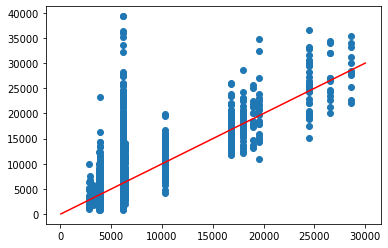

In [44]:
plt.scatter(p,y)
plt.plot([50,30000],[50,30000],"-r")
plt.show()

In [45]:
d = data.groupby(["d_pred"]).agg(écart_type = ("d_vrai", "std"), 
                                 compteur = ("d_pred", "count"),
                                 moyenne_vrai = ("d_vrai","mean"),
                                 minimum = ('d_vrai','min'),
                                 maximum = ('d_vrai','max'))

d.sort_values(by = 'd_pred', ascending = True)

,écart_type,compteur,moyenne_vrai,minimum,maximum
d_pred,,,,,
2768.065268,1843.676761,25,3117.600000,1020.0,9960.0
2879.752556,1435.196568,37,3123.243243,1680.0,7620.0
3221.526206,768.633391,82,3309.512195,1740.0,5700.0
3799.994822,1765.965860,203,4123.743842,900.0,12300.0
3848.543118,2351.691293,444,4294.189189,900.0,23280.0
6192.354990,5527.108435,977,7510.562948,900.0,39300.0
6375.227611,2471.224046,115,6811.304348,2100.0,14100.0
10333.046462,3125.023428,84,10778.571429,4200.0,19860.0
16739.111536,3050.160682,89,16997.528090,11760.0,26040.0


dans l'intervalle de confiance : 18% vs 22% ( good )

score R^2 : 0,57 vs 0,54 ( bizarre )
